# Importing the data

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
x = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
x.sample()

,id,airline,flight,source,departure,stops,arrival,destination,class,duration,days_left,price
6345,6345,Vistara,UK-834,Chennai,Evening,one,Afternoon,Hyderabad,Economy,19.17,48.0,3810


* Talking about the usefulness of all the columns present as not all column present are determining the price .
* So we drop the unnecessary ones that may lead to delay in processing of data .
* The only unnecessary col is -> id so we drop it .

In [10]:
x = x.drop('id',axis=1)
x.shape

(40000, 11)

In [11]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   airline      35387 non-null  object 
 1   flight       40000 non-null  object 
 2   source       40000 non-null  object 
 3   departure    35208 non-null  object 
 4   stops        37681 non-null  object 
 5   arrival      40000 non-null  object 
 6   destination  40000 non-null  object 
 7   class        40000 non-null  object 
 8   duration     36987 non-null  float64
 9   days_left    35562 non-null  float64
 10  price        40000 non-null  int64  
dtypes: float64(2), int64(1), object(8)
memory usage: 3.4+ MB


# Identify data types of different columns

In [12]:
x.dtypes

,0
airline,object
flight,object
source,object
departure,object
stops,object
arrival,object
destination,object
class,object
duration,float64
days_left,float64


Talking about the datatypes of various col present -
1. **Numerical** ->    price , days_left , duration   <- ( total = 3 ) .
Hence the dataype is float64 and int64
2. **Categorical** ->   airline , flight , source	, departure	, stops ,arrival ,	destination	 ,class   <- ( total = 8 ) .
Hence the dataype is object.

# Descriptive statistics of numerical columns

In [13]:
x.describe()

,duration,days_left,price
count,36987.000000,35562.000000,40000.00000
mean,12.004088,26.197936,20801.49025
std,7.108063,13.469232,22729.14842
min,0.830000,1.000000,1105.00000
25%,6.670000,15.000000,4687.00000
50%,11.080000,26.000000,7353.00000
75%,15.920000,38.000000,42521.00000
max,47.080000,49.000000,114704.00000


In [14]:
print( "Median" )
print( x['duration'].median() , x['days_left'].median() , x['price'].median() )

Median
11.08 26.0 7353.0


* **Duration ->** Max value=47.080000 , Min value=0.830000 , Mean=12.004088 , Median=11.75
* **Days_left  ->** Max value=49.000000 , Min value=1.000000 , Mean=26.197936 , Median=26.000000
* **Price ->**  Max value=114704.00000 , Min value=1105.00000 , Mean=20801.49025 , Median=7353.0

# Identifying  missing values

In [15]:
x.isnull().sum()

,0
airline,4613
flight,0
source,0
departure,4792
stops,2319
arrival,0
destination,0
class,0
duration,3013
days_left,4438


Columns with missing values are ->
1. **Numerical ->** duration , days_left
2. **Categorical ->** departure , stops , airline

## Plotting graphs for days_left & duration

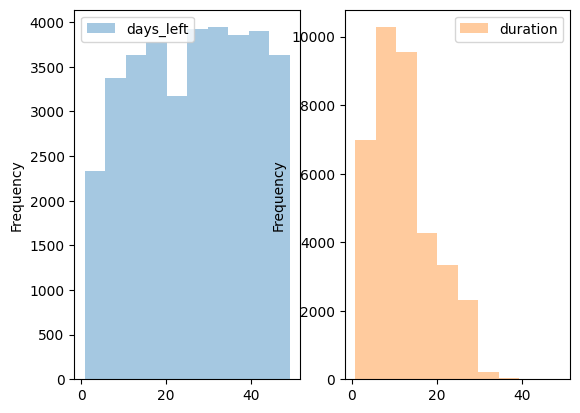

In [16]:
subplots = x[['days_left','duration']].plot(kind='hist', alpha=0.4 , subplots=True , layout=(1,2))

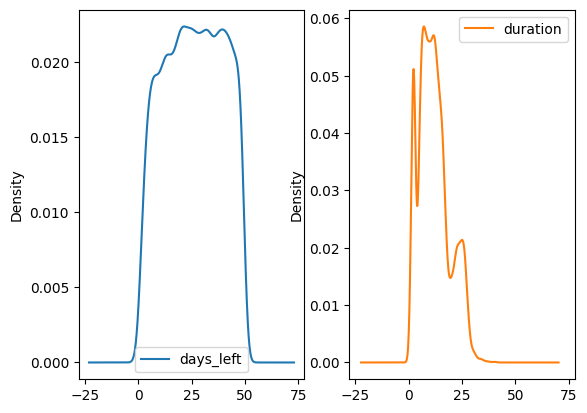

In [17]:
subplots = x[['days_left','duration']].plot(kind='kde', subplots=True , layout=(1,2))

The data in both the cases data almost peaked in the centre so we will fill in following ways -
1. **Days left ->** filling technique used be median as it is peaked in the centre
2. **Duration ->** filling technique used be mean as it is peaked in the centre

## Plotting graphs for departure , stops & airline

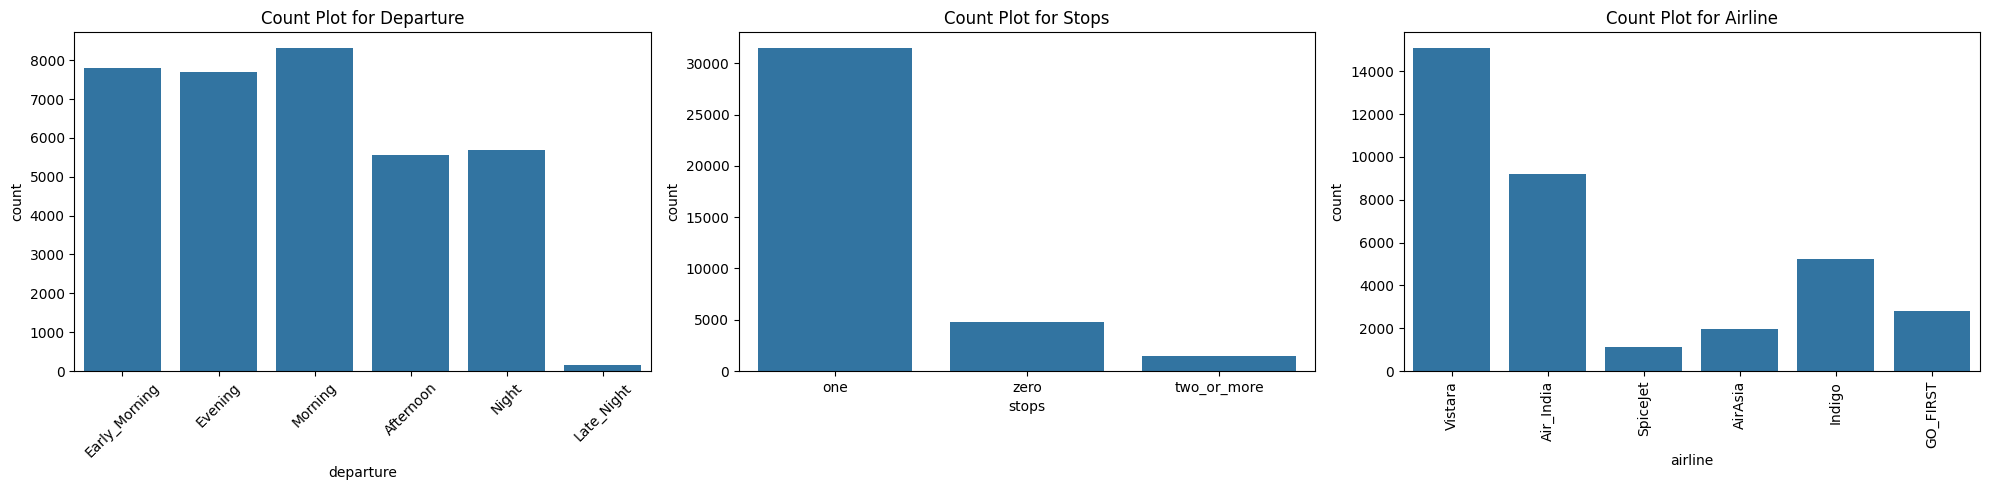

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(data=x, x='departure', ax=axes[0])
axes[0].set_title('Count Plot for Departure')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(data=x, x='stops', ax=axes[1])
axes[1].set_title('Count Plot for Stops')

sns.countplot(data=x, x='airline', ax=axes[2])
axes[2].set_title('Count Plot for Airline')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

We will fill in following ways -
1. **Stops ->** filling technique used be most frequent ie. Mode as 'one' is more than 50% of the data .
2. **Departure ->** filling technique used be most frequent ie. Mode
3. **Airline ->** Small % missing & might matter hence we fill Mode

# Identify and handling Duplicates ( Train & Test )

In [19]:
x.duplicated().sum()

np.int64(250)

In [20]:
x= x.drop_duplicates()
x.shape

(39750, 11)

# Outliers detection and removal

We used boxplots to visually detect outliers in numerical columns. Outliers appear as points far outside the box and whiskers, showing unusually high or low values that might affect our model’s performance.

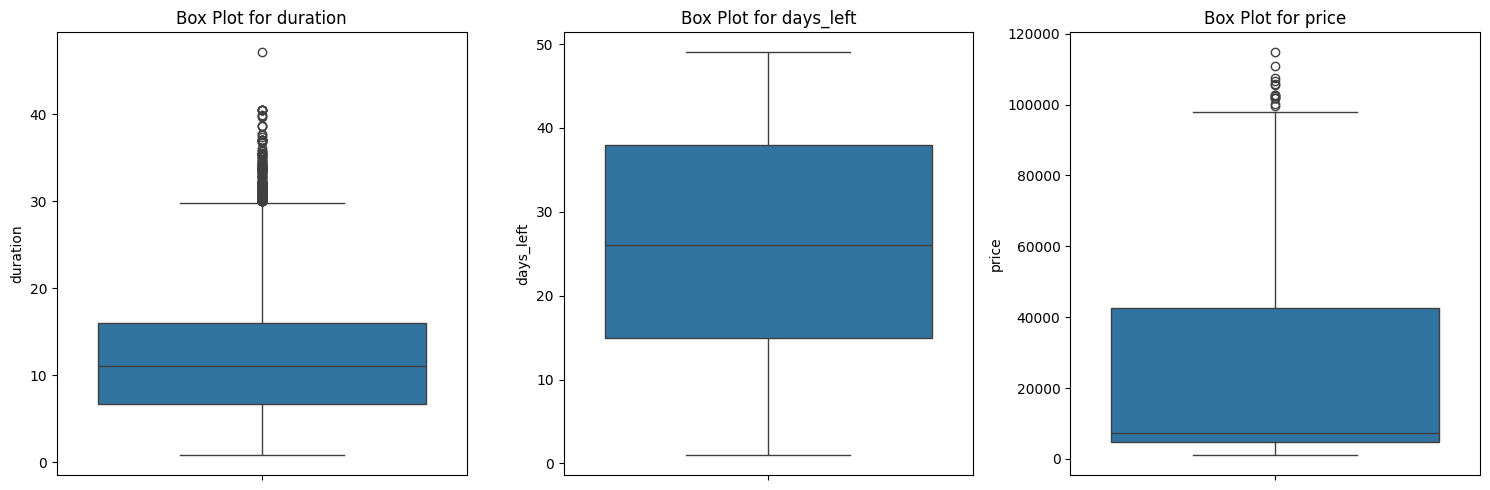

In [21]:
numerical_cols = x.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
        plt.subplot(1, len(numerical_cols[:3]), i + 1)
        sns.boxplot(y=x[col])
        plt.title(f'Box Plot for {col}')
plt.tight_layout()
plt.show()


We removed outliers using the IQR (Interquartile Range) method. This method keeps only the data within a reasonable range (between Q1 − 1.5×IQR and Q3 + 1.5×IQR). By dropping extreme values, we reduce the risk of unusual data points skewing our model’s training and predictions.

In [22]:
# removing the outliers from above columns using iqr
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned

# Remove outliers from numerical columns
for col in numerical_cols:
    x = remove_outliers_iqr(x, col)

print("Shape of data after removing outliers:", x.shape)

Shape of data after removing outliers: (32661, 11)


#  Data Visualization

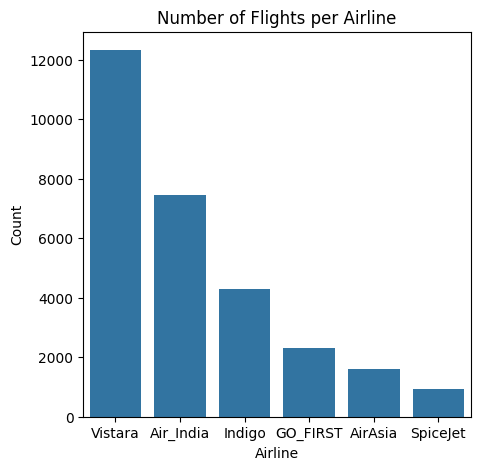

In [23]:
plt.figure(figsize=(5, 5))
sns.countplot(data=x, x='airline', order=x['airline'].value_counts().index)
plt.title('Number of Flights per Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.show()

**Insight :**
The data shows that Vistara dominates the flight operations in this sample, followed by other major carriers like Air India. SpiceJet, on the other hand, is underrepresented. This imbalance should be considered during modeling, as it may affect how categorical features like Airline influence the predictions.

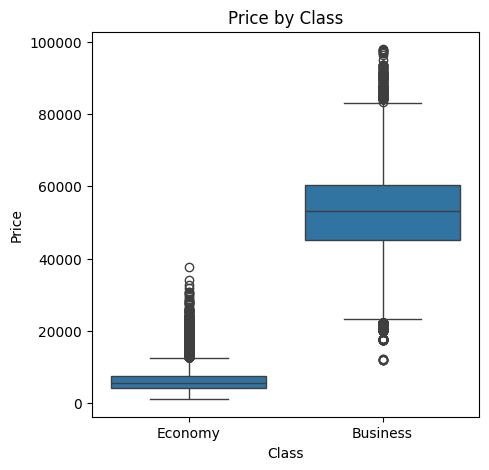

In [24]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=x, x='class', y='price')
plt.title('Price by Class')
plt.xlabel('Class')
plt.ylabel('Price')
plt.show()

**Insight:**  Fares for Business class are not only higher on average but also more dispersed, with more high-value outliers than Economy class. Economy prices remain lower and more concentrated. This highlights that travel class is a key driver of ticket prices.

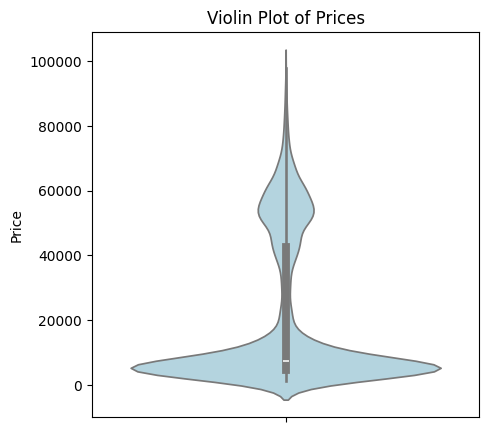

In [25]:
plt.figure(figsize=(5, 5))
sns.violinplot(y=x['price'], color='lightblue')
plt.title('Violin Plot of Prices')
plt.ylabel('Price')
plt.show()

**Insight:** Flight prices show a right-skewed distribution with tightly clustered low prices and a long tail of high-cost outliers. This skewness can impact modeling but can be addressed by log scaling to approximate a normal distribution.

# Train and Test data splitting

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x_train , x_test, y, y_test = train_test_split( x.drop('price', axis=1) , x['price'] ,test_size=0.2,random_state=42)

# Data Processing ->
1. Filling Missing Values ( Numerical & Categorical )
2. Scale Numerical features & Encode Categorical features

In [28]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

In [29]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [30]:
numerical_cols = ['duration', 'days_left']
categorical_cols = ['airline', 'flight', 'source', 'departure', 'stops', 'arrival', 'destination', 'class']

In [31]:
mean_fill = SimpleImputer( strategy = 'mean' )
mode_fill = SimpleImputer( strategy = 'most_frequent' )

In [32]:
encode = OrdinalEncoder(handle_unknown='ignore')
scale = MinMaxScaler()

1. Imputed — To fill in missing values so that the model doesnot break or get biased by gaps in the data.
2. Scaled — To bring all numeric features to a similar range so that no feature unfairly dominates the model due to larger values.

In [33]:
# Numerical pipeline
numerical_pipe = Pipeline( steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

1. Imputed — To fill missing categories with the most common one so no blanks confuse the model.
2. Encoded — To convert categories into numeric form so the model can understand and use them.

In [34]:
# Categorical pipeline
categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [35]:
numerical_cols_final = x_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols_final = x_train.select_dtypes(include='object').columns.tolist()

original_cols = x_train.columns.tolist()

numerical_indices = [original_cols.index(col) for col in numerical_cols_final]
categorical_indices = [original_cols.index(col) for col in categorical_cols_final]

In [36]:
preprocessor_pipeline = ColumnTransformer( transformers=[
        ('num', numerical_pipe , numerical_indices),
        ('cat', categorical_pipe , categorical_indices)
    ], remainder='passthrough' )

# Visulization of the preprocessed pipeline data that will be given to the model

In [37]:
from sklearn import set_config
set_config(display='diagram')
preprocessor_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 [8, 9]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [0, 1, 2, 3, 4, 5, 6, 7])])

# Model Making

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [39]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost Regressor": XGBRegressor(random_state=42),
    "Support Vector Regressor": SVR(),
    "K-Neighbors Regressor": KNeighborsRegressor()
}

In [40]:
results = {}

In [41]:
x_train_processed = preprocessor_pipeline.fit_transform(x_train, y)
x_test_processed = preprocessor_pipeline.transform(x_test)

In [42]:
# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...",)

    model.fit(x_train_processed, y)

    y_pred = model.predict(x_test_processed)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MSE": mse, "R2": r2}
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

Training Linear Regression...
Linear Regression - MSE: 40416180.3491, R2: 0.9226
Training Decision Tree Regressor...
Decision Tree Regressor - MSE: 17198291.3877, R2: 0.9671
Training Random Forest Regressor...
Random Forest Regressor - MSE: 9742561.9080, R2: 0.9813
Training Gradient Boosting Regressor...
Gradient Boosting Regressor - MSE: 23682652.0293, R2: 0.9546
Training XGBoost Regressor...
XGBoost Regressor - MSE: 13186572.0000, R2: 0.9747
Training Support Vector Regressor...
Support Vector Regressor - MSE: 674737732.8367, R2: -0.2926
Training K-Neighbors Regressor...
K-Neighbors Regressor - MSE: 37226149.3584, R2: 0.9287


# Comparison of model performances

In [43]:
print("\n--- Model Evaluation Results ---")
for name, metrics in results.items():
    print(f"{name}: MSE={metrics['MSE']:.4f}, R2: {metrics['R2']:.4f}")


--- Model Evaluation Results ---
Linear Regression: MSE=40416180.3491, R2: 0.9226
Decision Tree Regressor: MSE=17198291.3877, R2: 0.9671
Random Forest Regressor: MSE=9742561.9080, R2: 0.9813
Gradient Boosting Regressor: MSE=23682652.0293, R2: 0.9546
XGBoost Regressor: MSE=13186572.0000, R2: 0.9747
Support Vector Regressor: MSE=674737732.8367, R2: -0.2926
K-Neighbors Regressor: MSE=37226149.3584, R2: 0.9287


Random Forest did the best — it gave the lowest error and explained the most variation in prices.
Decision Tree and XGBoost also did very well, with small errors and high accuracy.
Linear Regression and K-Neighbors were okay, but not as good as the tree models.
Support Vector Regressor did badly — it didnot fit the data properly.
Gradient Boosting was fine, but Random Forest still beat it.

# Hyperparameter Tuning on 3 of the models

K-Neighbors Regressor

In [47]:
from sklearn.model_selection import GridSearchCV

values = {'n_neighbors': [20, 30, 40, 50, 60]}

grid_search_knn = GridSearchCV( KNeighborsRegressor(), values , cv=5, scoring='neg_mean_squared_error' , n_jobs=-1)

grid_search_knn.fit(x_train_processed, y)

print(f"Best parameters for K-Neighbors Regressor: {grid_search_knn.best_params_}")
print(f"Best cross-validation MSE r: {-grid_search_knn.best_score_:}")

best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(x_test_processed)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"Optimized  - Test MSE: {mse_knn:}, Test R2: {r2_knn:}")


Best parameters for K-Neighbors Regressor: {'n_neighbors': 20}
Best cross-validation MSE r: 48944705.21219971
Optimized  - Test MSE: 46391734.39939844, Test R2: 0.9111237262476856


Random Forest Regression

In [48]:
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [49]:
param_dist = {
    'n_estimators': randint(20, 60),
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)
random_search_rf = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=5, cv=2,
    scoring='neg_root_mean_squared_error', random_state=42, verbose=1
)
random_search_rf.fit(x_train_processed, y)

print(f"Best Cross-Validation RMSE: {-random_search_rf.best_score_:.4f}")
print(f"Best Parameters: {random_search_rf.best_params_}")

best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(x_test_processed)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Optimized Random Forest - Test MSE: {mse_rf:.4f}, Test R2: {r2_rf:.4f}")

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Cross-Validation RMSE: 3589.1503
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 48}
Optimized Random Forest - Test MSE: 9705535.5204, Test R2: 0.9814


Ridge Regression

In [50]:
from sklearn.linear_model import Ridge

ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_root_mean_squared_error')
grid_ridge.fit(x_train_processed, y)
print("Best Ridge RMSE:", -grid_ridge.best_score_)
print("Best Ridge Parameters:", grid_ridge.best_params_)

Best Ridge RMSE: 6319.946997514962
Best Ridge Parameters: {'alpha': 1}


# Final Model Selection

We can clearly see than **Random Forest Regression** gave us the best results so we will use that only for our final predictions

In [51]:
final_model = RandomForestRegressor( n_estimators=48, max_depth=None,
    min_samples_split=5, random_state=42 )

final_model.fit(x_train_processed, y)

final_predictions = final_model.predict(x_test_processed)

final_mse = mean_squared_error(y_test, final_predictions)
final_r2 = r2_score(y_test, final_predictions)

print(f"  Test MSE: {final_mse:.4f}")
print(f"  Test R2: {final_r2:.4f}")

  Test MSE: 9705535.5204
  Test R2: 0.9814


# Predictions

In [52]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
test_df.sample()

,id,airline,flight,source,departure,stops,arrival,destination,class,duration,days_left
5480,5480,Vistara,UK-876,Hyderabad,Night,one,Evening,Kolkata,Business,19.25,18.0


In [54]:
test_processed = preprocessor_pipeline.transform(test_df.drop('id', axis=1))

final_predictions = final_model.predict(test_processed)

submission_df = pd.DataFrame({'id': test_df['id']})
submission_df['price'] = final_predictions.astype(int)

submission_df.to_csv('/content/drive/MyDrive/Colab Notebooks/submission_final_predictions.csv', index=False)


Submission file saved to Google Drive.
